In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import time
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDyST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)
custom_library_path = os.path.abspath('util/gev/')
sys.path.append(custom_library_path)

import extraction_squares, pre_processing_data, data_processing

'''if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDyST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDyST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:'''
name_of_variable= pd.read_csv('pre_processing/feature_selection/fs_corr_timeseries/corr_inst_max_40.csv')['Unnamed: 0']#('data/variable_list_levels.csv')
path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
#dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'
levels = pd.read_csv('data/levels.csv')

In [3]:
# open time series data

stats = ['max', 'min', 'mean', 'std']
name_of_variable_levels = pd.read_csv('data/variable_list_levels.csv')
number_of_steps = 37

# shape all_data as the timeseries data
data_list = []
data_list_y = []
y_var_name = []
x_var_name = []

for var in name_of_variable_levels['variables']:
    if var == 'sea_surface_temperature':
        name_of_variable = name_of_variable.drop(name_of_variable[name_of_variable['variables'] == var].index)
        continue
    elif var == 'convective_rain_rate':
        name_of_variable = name_of_variable.drop(name_of_variable[name_of_variable['variables'] == var].index)
        continue
    elif var.startswith('vertical_velocity'):
        level = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 850, 900, 925, 950, 975, 1000]
        for lev in level:
            var_level = f'{var}_{lev}'
            name_of_variable = name_of_variable.drop(name_of_variable[name_of_variable['variables'] == var_level].index)
        continue
    for stat in stats:
        var_stat = f'{var}_{stat}'
        if var_stat == f'instantaneous_10m_wind_gust_{stat}':
            continue
            storm_data = []
            var_temp = pd.read_csv(f'data/PCA_loadings/{var}_{stat}.csv')
            try:
                var_temp = var_temp.drop(columns=['Unnamed: 0'])
            except:
                var_temp = var_temp
            '''var_temp = var_temp.to_numpy()
            name = np.repeat(var_stat, var_temp.shape[0])
            name = name[:, np.newaxis]
            var_temp = np.concatenate((name, var_temp), axis=1)'''
            storm_data.append(var_temp)
            y_var_name.append(var_stat)

            data_list_y.append(storm_data) 
        else :
            storm_data = []
            try: 
                var_temp = pd.read_csv(f'data/PCA_loadings/{var}_{stat}.csv')
            except :
                print(f'data/PCA_loadings/{var}_{stat}.csv does not exist')
                continue
            try :
                var_temp = var_temp.drop(columns=['Unnamed: 0'])
            except:
                var_temp = var_temp
            '''var_temp = var_temp.to_numpy()
            name = np.repeat(var_stat, var_temp.shape[0])
            name = name[:, np.newaxis]
            var_temp = np.concatenate((name, var_temp), axis=1)'''
            storm_data.append(var_temp)
            x_var_name.append(var_stat)

            data_list.append(storm_data)

# pad the data with zeros to have the same length for each storm

max_shape = (12, var_temp.shape[1])

# Convert all elements to NumPy arrays
data_list = [np.array(array) for array in data_list]

# Pad each array to have 12 rows (first dimension)
padded_data_list = []
for array in data_list:
    if data_list is None:
        continue
    current_rows = array.shape[0]
    padding = [(0, max_shape[0] - current_rows), (0, 0)]  # Pad rows, leave columns unchanged
    padded_array = np.pad(array, padding, mode='constant', constant_values=0)
    padded_data_list.append(padded_array)

# order of the data: storm, step, variable_stat
all_data = np.stack(data_list, axis=3)
all_data = np.concatenate(all_data, axis=0)

all_data_y = np.stack(data_list_y, axis=3)
all_data_y = np.concatenate(all_data_y, axis=0)
'''# keep only the max of the instantaneous wind gust
all_data_y = all_data_y[:, 0, :]
y_var_name = y_var_name[0]
'''
# get the storm indices
storm_indices = all_data[:,0, 0]
# Convert to float first, then to int
storm_indices = storm_indices.astype(float).astype(int)
# separate the data in training and testing
storm_index_training, storm_index_test, storm_index_validation = extraction_squares.split_storm_numbers(storm_indices, 0.15, 42)

# order the index of the storms

storm_index_training.sort()
storm_index_test.sort()
storm_index_validation.sort()

# add +1 to the storm index to match the storm index in the storm_dates dataframe (it's actually storm index for this set, so +1 is needed)
#storm_index_training = [x+1 for x in storm_index_training]
storm_index_test = [x+1 for x in storm_index_test]
#storm_index_validation = [x+1 for x in storm_index_validation]

actual_storm_training = []
actual_storm_test = []
actual_storm_validation = []


print("Storm Training:", storm_index_training)
print("Storm Test:", storm_index_test)
print("Storm Valid:", storm_index_validation) 

X_train = []
y_train = []
for i in range(len(storm_index_training)): 
    temp = all_data[all_data[:,0,0] == storm_index_training[i], :, :]
    temp_y = all_data_y[all_data_y[:,0,0] == storm_index_training[i], :,:]
    X_train.append(temp)
    y_train.append(temp_y)
    actual_storm_training.append(storm_dates[storm_dates['storm_index'] == storm_index_training[i]])

X_train = np.concatenate(X_train, axis=0)
X_train = X_train[:, 1:, :]
y_train = np.concatenate(y_train, axis=0)
y_train = y_train[:, 1:,:]

X_test = []
y_test = []
for i in range(len(storm_index_test)): 
    temp = all_data[all_data[:,0,0] == storm_index_test[i], :, :]
    temp_y = all_data_y[all_data_y[:,0,0] == storm_index_test[i], :,:]
    X_test.append(temp)
    y_test.append(temp_y)
    actual_storm_test.append(storm_dates[storm_dates['storm_index'] == storm_index_test[i]])

X_test = np.concatenate(X_test, axis=0)
X_test = X_test[:, 1:, :]
y_test = np.concatenate(y_test, axis=0)
y_test = y_test[:, 1:,:]

X_validation = []
y_validation = []

for i in range(len(storm_index_validation)):
    temp = all_data[all_data[:,0,0] == storm_index_validation[i], :, :]
    temp_y = all_data_y[all_data_y[:,0,0] == storm_index_validation[i], :,:]
    X_validation.append(temp)
    y_validation.append(temp_y)
    actual_storm_validation.append(storm_dates[storm_dates['storm_index'] == storm_index_validation[i]])

X_validation = np.concatenate(X_validation, axis=0)
X_validation = X_validation[:, 1:, :]
y_validation = np.concatenate(y_validation, axis=0)
y_validation = y_validation[:, 1:,:]

# add one dimension for each y

'''y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)
y_validation = np.expand_dims(y_validation, axis=2)'''

# X_train
X_train_standardized, y_train_standardized_max, y_train_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_train, y_train, name_of_variable, levels, True)
# X_test 
X_test_standardized, y_test_standardized_max, y_test_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_test, y_test, name_of_variable, levels, True)
# X_validation
X_validation_standardized, y_validation_standardized_max, y_validation_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_validation, y_validation, name_of_variable, levels, True)

# load the actual y values

y_all = pd.read_csv('data/climatology_dm_winter_per_cluster/GEV_CDF_max/log_cdf_max_combined.csv')
y_all = y_all.drop(columns=['storm_name'])

# transform the actual storm numbers
actual_storm_training = pd.concat(actual_storm_training)
actual_storm_test = pd.concat(actual_storm_test)
actual_storm_validation = pd.concat(actual_storm_validation)

actual_storm_training = actual_storm_training['storm_index'].to_numpy()
actual_storm_test = actual_storm_test['storm_index'].to_numpy()
actual_storm_validation = actual_storm_validation['storm_index'].to_numpy()

y_train = y_all[y_all['storm_number'].isin(storm_index_training)]
y_train = y_train.sort_values(by=['storm_number']).reset_index(drop=True)
y_train = y_train.drop(columns=['storm_number'])
y_train_np = y_train.to_numpy()
y_test = y_all[y_all['storm_number'].isin(storm_index_test)]
y_test = y_test.sort_values(by=['storm_number']).reset_index(drop=True)
y_test = y_test.drop(columns=['storm_number'])
y_test_np = y_test.to_numpy()
y_validation = y_all[y_all['storm_number'].isin(storm_index_validation)]
y_validation = y_validation.sort_values(by=['storm_number']).reset_index(drop=True)
y_validation = y_validation.drop(columns=['storm_number'])
y_validation_np = y_validation.to_numpy()

X_train_standardized_np = X_train_standardized.to_numpy()
unique_column_names = [f"{var}_{stat}_t{step}" for step in range(1, X_train.shape[1] + 1) for var in var_stat_all_x]
X_train_standardized_lgbm = X_train_standardized.copy()
X_train_standardized_lgbm.columns = unique_column_names
X_test_standardized_np = X_test_standardized.to_numpy()


data/PCA_loadings/specific_rain_water_content_10_max.csv does not exist
data/PCA_loadings/specific_rain_water_content_10_min.csv does not exist
data/PCA_loadings/specific_rain_water_content_10_mean.csv does not exist
data/PCA_loadings/specific_rain_water_content_10_std.csv does not exist
data/PCA_loadings/specific_rain_water_content_20_max.csv does not exist
data/PCA_loadings/specific_rain_water_content_20_min.csv does not exist
data/PCA_loadings/specific_rain_water_content_20_mean.csv does not exist
data/PCA_loadings/specific_rain_water_content_20_std.csv does not exist
data/PCA_loadings/specific_rain_water_content_30_max.csv does not exist
data/PCA_loadings/specific_rain_water_content_30_min.csv does not exist
data/PCA_loadings/specific_rain_water_content_30_mean.csv does not exist
data/PCA_loadings/specific_rain_water_content_30_std.csv does not exist
data/PCA_loadings/specific_rain_water_content_50_max.csv does not exist
data/PCA_loadings/specific_rain_water_content_50_min.csv does

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2)  and requested shape (3,2)

In [2]:
def prepare_training_data(transposed_data, storm_index_training, updated_columns):
    """
    Prepare training data by filtering and concatenating rows based on storm indices.

    Parameters:
        transposed_data (pd.DataFrame): The input DataFrame containing data to filter.
        storm_index_training (list): List of storm indices to filter the data by.
        updated_columns (list): List of column names to update the resulting DataFrame.

    Returns:
        pd.DataFrame: The processed training data with specified columns and without 'storm_number'.
    """
    X_train = []
    
    for storm_index in storm_index_training:
        temp = transposed_data[transposed_data['storm_number'] == storm_index]
        X_train.append(temp)
    
    # Concatenate the filtered data
    X_train = np.concatenate(X_train, axis=0)
    
    # Convert to DataFrame
    X_train = pd.DataFrame(X_train, columns=updated_columns)
    
    # Drop the 'storm_number' column
    X_train = X_train.drop(columns=['storm_number'])
    
    return X_train

In [5]:
# import the all_loadings data
all_loadings = pd.read_csv('pre_processing/nestedMLR/all_loadings.csv')

# Extract variable names and storm data
variables = all_loadings['variable']  # First column
storm_data = all_loadings.iloc[:, 1:]  # All columns from the second onward

# Transpose storm data and set variable names as columns
transposed_data = storm_data.T
transposed_data.columns = variables

# Optionally reset index to name storms
transposed_data.index.name = 'storm_number'
transposed_data.reset_index(inplace=True)

original_data = transposed_data.copy()
original_columns = transposed_data.columns
original_data['storm_number'] = original_data['storm_number'].astype(int)
# Add PCA numbers to each variable to differentiate modes
# Count how many times each variable appears in the column names
variable_counts = transposed_data.columns.value_counts()

# Create a mapping with PCA numbers appended to each variable
updated_columns = []
pca_tracker = {}

for var in transposed_data.columns:
    if var not in pca_tracker:
        pca_tracker[var] = 1
    else:
        pca_tracker[var] += 1
    # Append PCA number to the variable name
    updated_columns.append(f"{var}_PCA_{pca_tracker[var]}")

# Update the column names
transposed_data.columns = updated_columns

# rename the first column to storm_number
transposed_data = transposed_data.rename(columns={'storm_number_PCA_1': 'storm_number'})

transposed_data['storm_number'] = transposed_data['storm_number'].astype(int)
# Extract storm indices
storm_indices = transposed_data['storm_number'].to_numpy()
# separate the data in training and testing
storm_index_training, storm_index_test, storm_index_validation = extraction_squares.split_storm_numbers(storm_indices, 0.12, 42, 'number')

# order the index of the storms

storm_index_training.sort()
storm_index_test.sort()
storm_index_validation.sort()

# add +1 to the storm index to match the storm index in the storm_dates dataframe (it's actually storm index for this set, so +1 is needed)
#storm_index_training = [x+1 for x in storm_index_training]
#storm_index_test = [x+1 for x in storm_index_test]
#storm_index_validation = [x+1 for x in storm_index_validation]

print("Storm Training:", storm_index_training)
print("Storm Test:", storm_index_test)
print("Storm Valid:", storm_index_validation) 

# remove the variable convective_rain_rate and vertical_velocity
columns_to_drop = transposed_data.columns[transposed_data.columns.str.startswith(('convective_rain_rate', 'vertical_velocity'))]
transposed_data = transposed_data.drop(columns=columns_to_drop)

# Update the column names
updated_columns = transposed_data.columns

X_train = []
for i in range(len(storm_index_training)): 
    temp = transposed_data[transposed_data['storm_number'] == storm_index_training[i]]
    X_train.append(temp)
X_train = np.concatenate(X_train, axis=0)
X_train = pd.DataFrame(X_train)
X_train.columns = updated_columns
X_train = X_train.drop(columns=['storm_number'])

X_validation = []
for i in range(len(storm_index_validation)):
    temp = transposed_data[transposed_data['storm_number'] == storm_index_validation[i]]
    X_validation.append(temp)
X_validation = np.concatenate(X_validation, axis=0)
X_validation = pd.DataFrame(X_validation)
X_validation.columns = updated_columns
X_validation = X_validation.drop(columns=['storm_number'])

# without the PCA in the names :

X_train_original = prepare_training_data(original_data, storm_index_training, original_columns)
X_validation_original = prepare_training_data(original_data, storm_index_validation, original_columns)
X_test_original = prepare_training_data(original_data, storm_index_test, original_columns)

# now take only the variables in the columns from name_of_variable

columns_to_select = [col for col in name_of_variable.tolist() if col in X_train_original.columns]

X_train_original = X_train_original[columns_to_select]
X_validation_original = X_validation_original[columns_to_select]
X_test_original = X_test_original[columns_to_select]

# load the actual y values

y_all = pd.read_csv('data/climatology_dm_winter_per_cluster/GEV_CDF_max/log_cdf_max_combined.csv')
y_all = y_all.drop(columns=['storm_name'])

y_all_raw = pd.read_csv('data/climatology_dm_winter_per_cluster/EVENT_max/max_event_combined.csv')
y_all_raw = y_all_raw.drop(columns=['storm_name'])

y_train = y_all[y_all['storm_number'].isin(storm_index_training)]
y_train = y_train.sort_values(by=['storm_number']).reset_index(drop=True)
y_train = y_train.drop(columns=['storm_number'])
y_train_np = y_train.to_numpy()
y_test = y_all[y_all['storm_number'].isin(storm_index_test)]
y_test = y_test.sort_values(by=['storm_number']).reset_index(drop=True)
y_test = y_test.drop(columns=['storm_number'])
y_test_np = y_test.to_numpy()
y_validation = y_all[y_all['storm_number'].isin(storm_index_validation)]
y_validation = y_validation.sort_values(by=['storm_number']).reset_index(drop=True)
y_validation = y_validation.drop(columns=['storm_number'])
y_validation_np = y_validation.to_numpy()

y_train_raw = y_all_raw[y_all_raw['storm_number'].isin(storm_index_training)]
y_train_raw = y_train_raw.sort_values(by=['storm_number']).reset_index(drop=True)
y_train_raw = y_train_raw.drop(columns=['storm_number'])
y_train_raw_np = y_train_raw.to_numpy()
y_test_raw = y_all_raw[y_all_raw['storm_number'].isin(storm_index_test)]
y_test_raw = y_test_raw.sort_values(by=['storm_number']).reset_index(drop=True)
y_test_raw = y_test_raw.drop(columns=['storm_number'])
y_test_raw_np = y_test_raw.to_numpy()
y_validation_raw = y_all_raw[y_all_raw['storm_number'].isin(storm_index_validation)]
y_validation_raw = y_validation_raw.sort_values(by=['storm_number']).reset_index(drop=True)
y_validation_raw = y_validation_raw.drop(columns=['storm_number'])
y_validation_raw_np = y_validation_raw.to_numpy()

To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Storm Training: [1, 2, 3, 5, 7, 8, 11, 12, 13, 16, 19, 26, 27, 31, 32, 34, 39, 43, 45, 46, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 85, 87, 89, 90, 95]
Storm Test: [6, 29, 38, 48, 66, 86, 93]
Storm Valid: [21, 33, 44, 47, 58, 83]


# Shape the data for multiple outputs

The shape should be like (storms, variables * steps)

In [6]:
'''# Initialize and train RandomForest
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train_np)  # y shape is (49, 14)

# Predictions
predictions_rf = model_rf.predict(X_validation)'''

# Initialize and train XGBoost with a multi-output wrapper
model_xgb = (XGBRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
X_train_np = X_train_original.to_numpy()
model_xgb.fit(X_train_np, y_train_raw_np)

# Predictions
X_validation_np = X_validation_original.to_numpy()
predictions_xgb = model_xgb.predict(X_validation_np)

# Initialize and train LightGBM with a multi-output wrapper
# Generate unique column names for each time step

'''unique_column_names = [f"{var}_{stat}_t{step}" for step in range(1, X_train.shape[1] + 1) for var in var_stat_all_x]
X_train_standardized_lgbm = X_train_standardized.copy()
X_train_standardized_lgbm.columns = unique_column_names'''
'''
model_lgbm = MultiOutputRegressor(LGBMRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
model_lgbm.fit(X_train_np, y_train_np)

# Predictions
predictions_lgbm = model_lgbm.predict(X_validation_np)

# Initialize and train GradientBoosting with a multi-output wrapper
model_gb = MultiOutputRegressor(GradientBoostingRegressor(random_state=42)) #MultiOutputRegressor
model_gb.fit(X_train_np, y_train_np)

# Predictions
predictions_gb = model_gb.predict(X_validation_np)'''

'\nmodel_lgbm = MultiOutputRegressor(LGBMRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor\nmodel_lgbm.fit(X_train_np, y_train_np)\n\n# Predictions\npredictions_lgbm = model_lgbm.predict(X_validation_np)\n\n# Initialize and train GradientBoosting with a multi-output wrapper\nmodel_gb = MultiOutputRegressor(GradientBoostingRegressor(random_state=42)) #MultiOutputRegressor\nmodel_gb.fit(X_train_np, y_train_np)\n\n# Predictions\npredictions_gb = model_gb.predict(X_validation_np)'

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def evaluate_models(y_true, predictions_dict):
    """
    Evaluate RMSE, MAE, and transformed RMSE for multiple models.

    Parameters:
    - y_true (array-like): Ground truth (true) target values.
    - predictions_dict (dict): Dictionary where keys are model names and values are predictions.

    Returns:
    - results (dict): Dictionary containing RMSE, MAE, and transformed RMSE metrics for each model.
    """
    results = {}
    y_true_real = 1 - np.exp(-y_true)  # Transform y_true to real units

    for model_name, predictions in predictions_dict.items():
        # Calculate RMSE and MAE
        rmse = sqrt(mean_squared_error(y_true, predictions))
        mae = mean_absolute_error(y_true, predictions)

        # Transform predictions to real units
        predictions_real = 1 - np.exp(-predictions)

        # Calculate transformed RMSE
        rmse_real = sqrt(mean_squared_error(y_true_real, predictions_real))

        # Calculate return RMSE
        return_rmse = round((1 / (1 - rmse_real)) / 2, 2)

        # Store results for the current model
        results[model_name] = {
            "RMSE": rmse,
            "MAE": mae,
            "Transformed RMSE": rmse_real,
            "Return RMSE": return_rmse
        }
    
    return results

# Evaluate models
predictions_dict = {
    #"RandomForest": predictions_rf,
    "XGBoost": predictions_xgb,
    #"LightGBM": predictions_lgbm,
    #"GradientBoosting": predictions_gb
}

results = evaluate_models(y_validation_raw_np, predictions_dict)

# Print results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print()

Model: XGBoost
RMSE: 5.877751881980368
MAE: 4.669421810328088
Transformed RMSE: 1.8944383738315922e-06
Return RMSE: 0.5



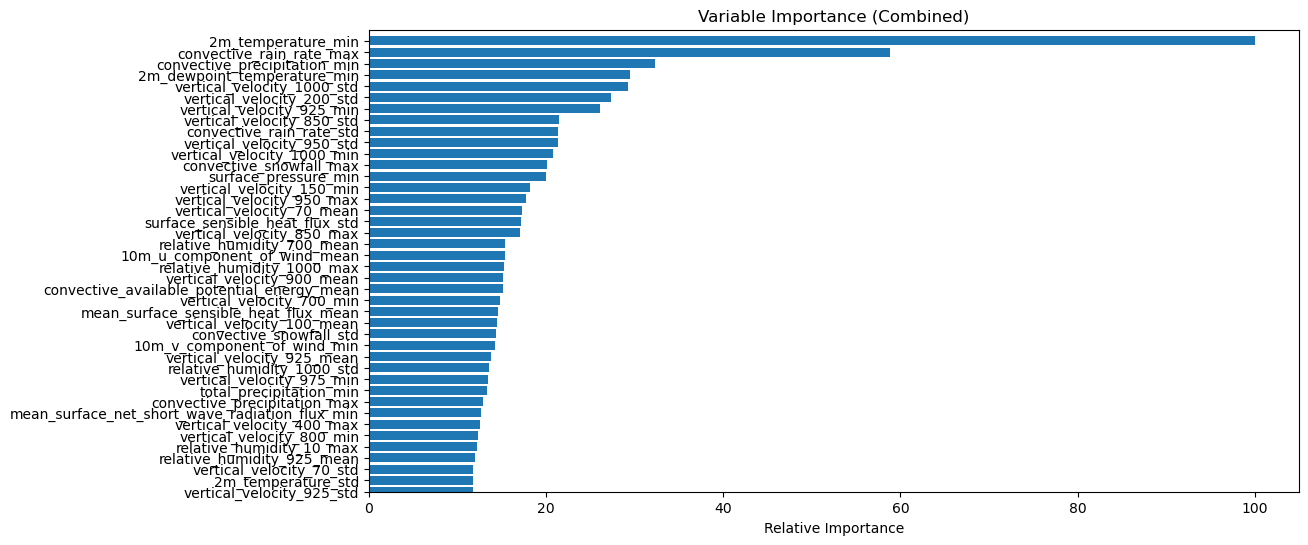

In [ ]:
# see the feature importance of the random forest
feature_importance = model_rf.feature_importances_
variable_names = X_train.columns  # Assuming it's a pandas Index or list

# Create a DataFrame to facilitate grouping
importance_df = pd.DataFrame({
    'variable': variable_names,
    'importance': feature_importance
})

# Extract base variable names (e.g., "2m_temperature" from "2m_temperature_t1")
# Adjust the regex if your variable naming convention differs
importance_df['base_variable'] = importance_df['variable'].str.extract(r'(^[a-zA-Z0-9_]+)_PCA_[0-9]+')

# Group by base variable name and sum the importance scores
grouped_importance = (
    importance_df.groupby('base_variable', as_index=False)
    .agg({'importance': 'sum'})
)

# Normalize importance scores
grouped_importance['importance'] = 100.0 * (grouped_importance['importance'] / grouped_importance['importance'].max())

# Sort by importance
grouped_importance = grouped_importance.sort_values('importance', ascending=False)

# Plot the combined feature importance
plt.figure(figsize=(12, 6))
plt.barh(grouped_importance['base_variable'], grouped_importance['importance'], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Combined)')
plt.ylim(-1, 40)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance on top
plt.show()

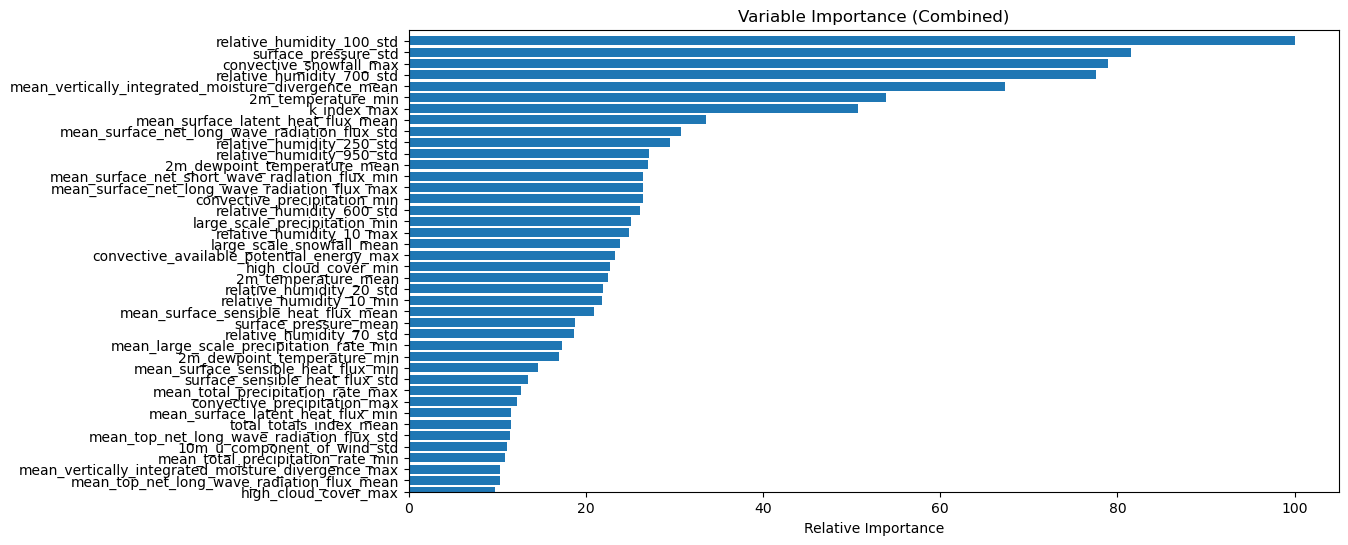

In [17]:
# see the feature importance of the xgboost
feature_importance_xgb = model_xgb.feature_importances_
variable_names_xgb = X_train.columns  # Assuming it's a pandas Index or list

# Create a DataFrame to facilitate grouping
importance_df_xgb = pd.DataFrame({
    'variable': variable_names_xgb,
    'importance': feature_importance_xgb
})

# Extract base variable names (e.g., "2m_temperature" from "2m_temperature_t1")
# Adjust the regex if your variable naming convention differs
importance_df_xgb['base_variable'] = importance_df_xgb['variable'].str.extract(r'(^[a-zA-Z0-9_]+)_PCA_[0-9]+')
# Group by base variable name and sum the importance scores
grouped_importance_xgb = (
    importance_df_xgb.groupby('base_variable', as_index=False)
    .agg({'importance': 'sum'})
)

# Normalize importance scores
grouped_importance_xgb['importance'] = 100.0 * (grouped_importance_xgb['importance'] / grouped_importance_xgb['importance'].max())

# Sort by importance
grouped_importance_xgb = grouped_importance_xgb.sort_values('importance', ascending=False)

# Plot the combined feature importance
plt.figure(figsize=(12, 6))
plt.barh(grouped_importance_xgb['base_variable'], grouped_importance_xgb['importance'], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Combined)')
plt.ylim(-1, 40)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance on top
plt.show()

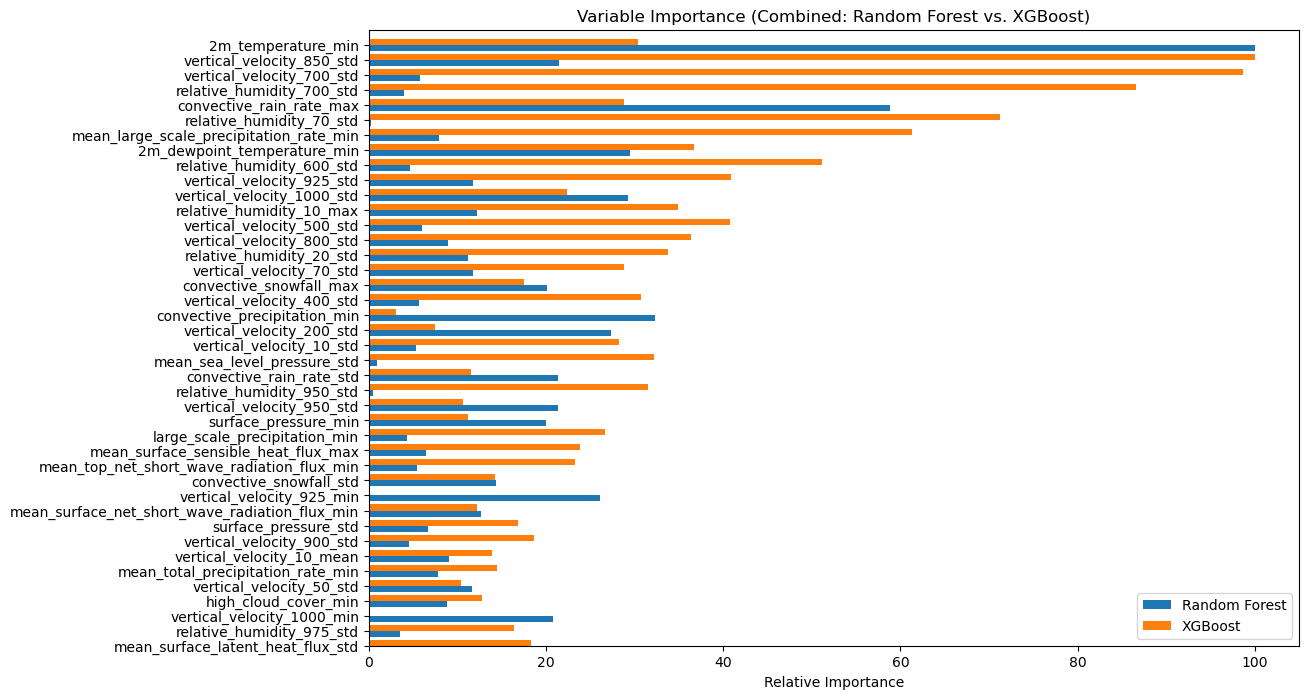

In [7]:
# Merge the two importance DataFrames on the 'base_variable' column
combined_importance = pd.merge(
    grouped_importance,
    grouped_importance_xgb,
    on='base_variable',
    how='outer',
    suffixes=('_rf', '_xgb')
)

# Fill NaN values with 0 (in case some variables are present in one model but not the other)
combined_importance.fillna(0, inplace=True)

# Sort by the sum of importance scores for better visualization
combined_importance['total_importance'] = combined_importance['importance_rf'] + combined_importance['importance_xgb']
combined_importance = combined_importance.sort_values('total_importance', ascending=False)

# Plot the combined feature importance
plt.figure(figsize=(12, 8))
bar_width = 0.4
index = range(len(combined_importance))

plt.barh(
    [i + bar_width / 2 for i in index],
    combined_importance['importance_rf'],
    bar_width,
    label='Random Forest'
)
plt.barh(
    [i - bar_width / 2 for i in index],
    combined_importance['importance_xgb'],
    bar_width,
    label='XGBoost'
)

# Add labels, title, and legend
plt.yticks(index, combined_importance['base_variable'])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Combined: Random Forest vs. XGBoost)')
plt.legend()
plt.ylim(-1, 40)
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()

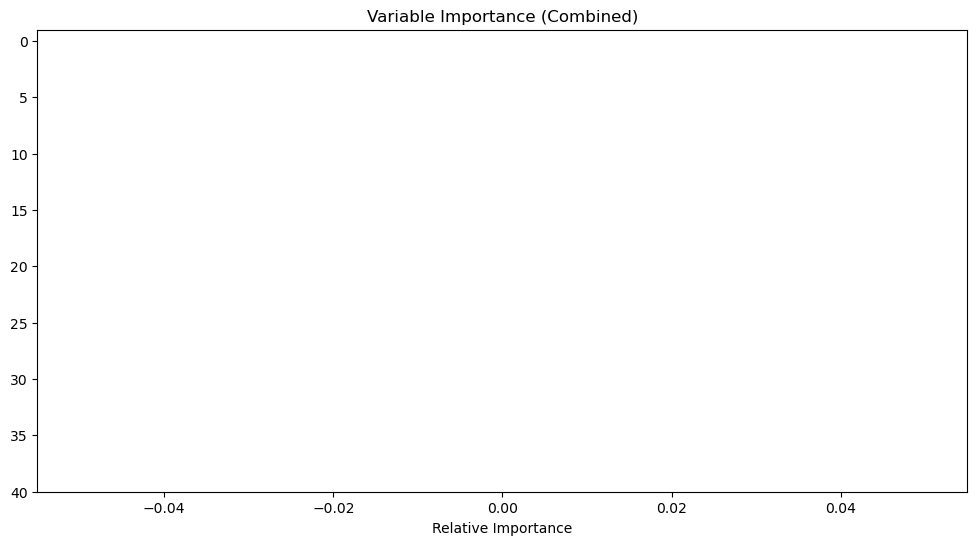

In [11]:
# see the feature importance of the lightgbm
feature_importance_lgbm = model_lgbm.estimators_[0].feature_importances_
variable_names_lgbm = X_train.columns  # Assuming it's a pandas
# Create a DataFrame to facilitate grouping
importance_df_lgbm = pd.DataFrame({
    'variable': variable_names_lgbm,
    'importance': feature_importance_lgbm
})

# Extract base variable names (e.g., "2m_temperature" from "2m_temperature_t1")
# Adjust the regex if your variable naming convention differs
importance_df_lgbm['base_variable'] = importance_df_lgbm['variable'].str.extract(r'^([a-zA-Z0-9_]+)_t[0-9]+')
# Group by base variable name and sum the importance scores
grouped_importance_lgbm = (
    importance_df_lgbm.groupby('base_variable', as_index=False)
    .agg({'importance': 'sum'})
)

# Normalize importance scores
grouped_importance_lgbm['importance'] = 100.0 * (grouped_importance_lgbm['importance'] / grouped_importance_lgbm['importance'].max())

# Sort by importance
grouped_importance_lgbm = grouped_importance_lgbm.sort_values('importance', ascending=False)

# Plot the combined feature importance
plt.figure(figsize=(12, 6))
plt.barh(grouped_importance_lgbm['base_variable'], grouped_importance_lgbm['importance'], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Combined)')
plt.ylim(-1, 40)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance on top
plt.show()

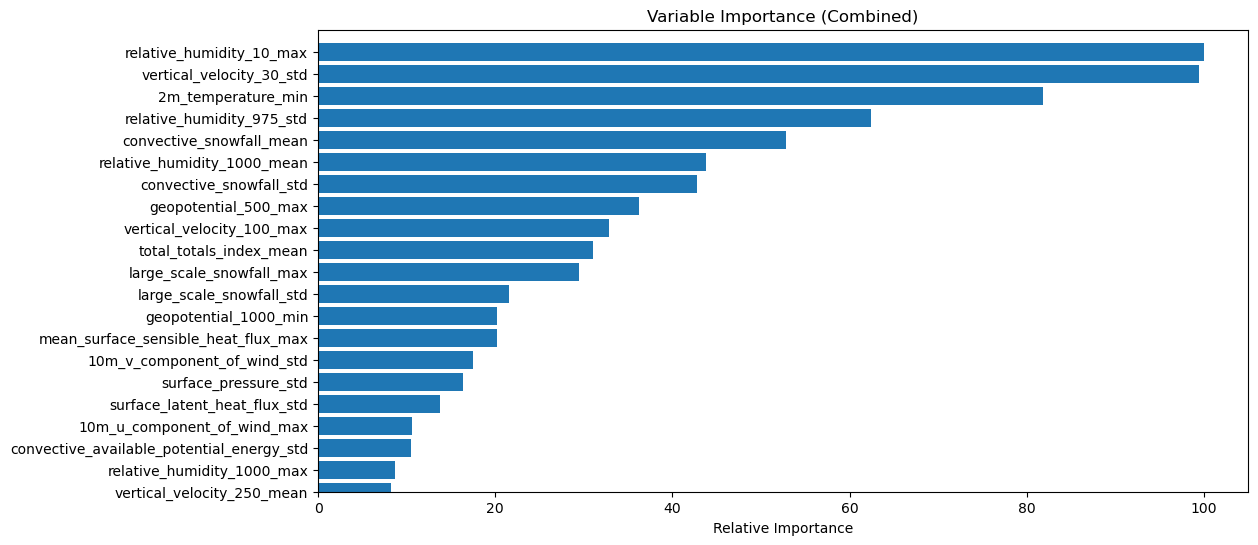

In [14]:
# see the feature importance of the gradient boosting
feature_importance_gb = model_gb.estimators_[0].feature_importances_
variable_names_gb = X_train.columns  # Assuming it's a pandas Index
# Create a DataFrame to facilitate grouping
importance_df_gb = pd.DataFrame({
    'variable': variable_names_gb,
    'importance': feature_importance_gb
})

# Extract base variable names (e.g., "2m_temperature" from "2m_temperature_t1")
# Adjust the regex if your variable naming convention differs
importance_df_gb['base_variable'] = importance_df_gb['variable'].str.extract(r'(^[a-zA-Z0-9_]+)_PCA_[0-9]+')
# Group by base variable name and sum the importance scores
grouped_importance_gb = (
    importance_df_gb.groupby('base_variable', as_index=False)
    .agg({'importance': 'sum'})
)

# Normalize importance scores
grouped_importance_gb['importance'] = 100.0 * (grouped_importance_gb['importance'] / grouped_importance_gb['importance'].max())

# Sort by importance
grouped_importance_gb = grouped_importance_gb.sort_values('importance', ascending=False)

# Plot the combined feature importance
plt.figure(figsize=(12, 6))
plt.barh(grouped_importance_gb['base_variable'], grouped_importance_gb['importance'], align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Combined)')
plt.ylim(-1, 20)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance on top
plt.show()

In [9]:
X_train.to_csv('pre_processing/nestedMLR/X_train.csv')
y_train.to_csv('pre_processing/nestedMLR/y_train.csv')

# use sequential selection for selecting the right features

In [9]:
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize the sequential feature selector
sfs = SequentialFeatureSelector(
                                model_xgb,  # Use the same model as before
                                n_features_to_select=5,  # Select 5 features
                                direction='forward',  # Forward selection
                                n_jobs=-1  # Use all available cores
                                )   

# Fit the SFS model
sfs.fit(X_train_original, y_train_raw_np)

SequentialFeatureSelector(estimator=XGBRegressor(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 random_state=42, ...),
                          n_features_to_select=5, n_jobs=-1)

In [11]:
# Get the selected feature indices
selected_features = sfs.get_support(indices=True)

# Get the selected feature names
selected_feature_names = X_train_original.columns[selected_features]

# Print the selected feature names
print(selected_feature_names)

'''# Initialize the sequential feature selector
sfs_xgb = SequentialFeatureSelector(
    model_xgb,  # Use the same model as before
    n_features_to_select=50,  # Select 5 features
    direction='forward',  # Forward selection
    n_jobs=-1  # Use all available cores
)'''

Index(['mean_surface_latent_heat_flux_std', 'mean_sea_level_pressure_max',
       'surface_latent_heat_flux_mean', 'surface_pressure_std',
       'surface_pressure_std'],
      dtype='object', name='variable')


"# Initialize the sequential feature selector\nsfs_xgb = SequentialFeatureSelector(\n    model_xgb,  # Use the same model as before\n    n_features_to_select=50,  # Select 5 features\n    direction='forward',  # Forward selection\n    n_jobs=-1  # Use all available cores\n)"

# tune the 4 models

In [17]:
# Random Forest
param_grid_rf = {
    'n_estimators': np.arange(100, 300, 50),  # Number of trees in the forest
    'max_depth': [10, 20, 30], # Maximum depth of the trees
    #'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split a node
    #'min_samples_leaf': [1, 2, 4],       # Minimum number of samples required in a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features considered for splitting
    'bootstrap': [True, False]           # Whether to use bootstrap samples
}

# XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 10, 20, 40],
    'learning_rate': np.linspace(0.05,0.2,4)
}

# LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Gradient Boosting
param_grid_gb = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [10, 20, 30],
    'estimator__learning_rate': [0.1, 0.01, 0.001]
}

# Random Forest
search_rf = HalvingGridSearchCV(model_rf, 
                                param_grid_rf, 
                                cv=2, 
                                n_jobs=-1, 
                                verbose=1, 
                                min_resources=10
                                )
search_rf.fit(X_train, y_train_np)

# XGBoost
search_xgb = HalvingGridSearchCV(model_xgb, param_grid_xgb, cv=2, n_jobs=-1, verbose=1)
search_xgb.fit(X_train, y_train_np)

'''# LightGBM
search_lgbm = HalvingGridSearchCV(model_lgbm, param_grid_lgbm, cv=5, n_jobs=-1, verbose=1)
search_lgbm.fit(X_train, y_train_np)'''

# Gradient Boosting
search_gb = HalvingGridSearchCV(model_gb, param_grid_gb, cv=2, n_jobs=-1, verbose=1)
search_gb.fit(X_train, y_train_np)

n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 10
max_resources_: 46
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 10
Fitting 2 folds for each of 48 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 16
n_resources: 30
Fitting 2 folds for each of 16 candidates, totalling 32 fits
n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 4
max_resources_: 46
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 4
Fitting 2 folds for each of 80 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 27
n_resources: 12
Fitting 2 folds for each of 27 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 9
n_resources: 36
Fitting 2 folds for each of 9 candidates, totalling 18 fits
n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 4
max_resources_: 46
aggressive_elimination: False
factor: 3
-------

HalvingGridSearchCV(cv=2,
                    estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)),
                    n_jobs=-1,
                    param_grid={'estimator__learning_rate': [0.1, 0.01, 0.001],
                                'estimator__max_depth': [10, 20, 30],
                                'estimator__n_estimators': [100, 200, 300]},
                    verbose=1)

In [20]:
# saved all the models 

# Random Forest
model_rf_custom = search_rf.best_estimator_
model_rf_custom.fit(X_train, y_train_np)

# XGBoost
model_xgb_custom = search_xgb.best_estimator_
model_xgb_custom.fit(X_train_np, y_train_np)

'''# LightGBM
model_lgbm_custom = search_lgbm.best_estimator_
model_lgbm_custom.fit(X_train_standardized_lgbm, y_train_np)'''

# Gradient Boosting
model_gb_custom = search_gb.best_estimator_
model_gb_custom.fit(X_train, y_train_np)

# save as pickle
data_processing.save_to_pickle(model_rf_custom, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_rf_custom.pkl')
data_processing.save_to_pickle(model_xgb_custom, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom.pkl')
#data_processing.save_to_pickle(model_lgbm_custom, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_lgbm_custom.pkl')
data_processing.save_to_pickle(model_gb_custom, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_gb_custom.pkl')

data_processing.save_to_pickle(model_rf, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_rf.pkl')
data_processing.save_to_pickle(model_xgb, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb.pkl')
data_processing.save_to_pickle(model_lgbm, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_lgbm.pkl')
data_processing.save_to_pickle(model_gb, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_gb.pkl')

# load the models, see thir accuracy and predictions

In [21]:
# import the models
model_rf_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_rf_custom.pkl')
model_xgb_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom.pkl')
model_lgbm_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_lgbm_custom.pkl')
model_gb_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_gb_custom.pkl')

model_rf = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_rf.pkl')
model_xgb = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb.pkl')
model_lgbm = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_lgbm.pkl')
model_gb = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_gb.pkl')


In [ ]:
# check the rmse and mae of the models
# Random Forest
predictions_rf_custom = model_rf_custom.predict(X_validation)
rmse_rf_custom = sqrt(mean_squared_error(y_validation_np, predictions_rf_custom))
mae_rf_custom = mean_absolute_error(y_validation_np, predictions_rf_custom)

predictions_rf = model_rf.predict(X_validation)
rmse_rf = sqrt(mean_squared_error(y_validation_np, predictions_rf))
mae_rf = mean_absolute_error(y_validation_np, predictions_rf)

# XGBoost
predictions_xgb_custom = model_xgb_custom.predict(X_validation)
rmse_xgb_custom = sqrt(mean_squared_error(y_validation_np, predictions_xgb_custom))
mae_xgb_custom = mean_absolute_error(y_validation_np, predictions_xgb_custom)

predictions_xgb = model_xgb.predict(X_validation)
rmse_xgb = sqrt(mean_squared_error(y_validation_np, predictions_xgb))
mae_xgb = mean_absolute_error(y_validation_np, predictions_xgb)

# LightGBM
predictions_lgbm_custom = model_lgbm_custom.predict(X_validation)
rmse_lgbm_custom = sqrt(mean_squared_error(y_validation_np, predictions_lgbm_custom))
mae_lgbm_custom = mean_absolute_error(y_validation_np, predictions_lgbm_custom)

predictions_lgbm = model_lgbm.predict(X_validation)
rmse_lgbm = sqrt(mean_squared_error(y_test_np, predictions_lgbm))
mae_lgbm = mean_absolute_error(y_test_np, predictions_lgbm)

# Gradient Boosting
predictions_gb_custom = model_gb_custom.predict(X_validation)
rmse_gb_custom = sqrt(mean_squared_error(y_test_np, predictions_gb_custom))
mae_gb_custom = mean_absolute_error(y_test_np, predictions_gb_custom)

predictions_gb = model_gb.predict(X_validation)
rmse_gb = sqrt(mean_squared_error(y_test_np, predictions_gb))
mae_gb = mean_absolute_error(y_test_np, predictions_gb)



NameError: name 'X_test_standardized' is not defined